# Assignment 9: PyTorch

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import skimage  # Package name: scikit-image, requires installation of package 'Pillow'
import skimage.io
import skimage.transform
import torch  # Package name: torch (for pip), pytorch (for conda)
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

In [ ]:
def load_airfoil_dataset():
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    
    data = np.genfromtxt('airfoil_self_noise.csv')
    X, y = data[:, :5], data[:, 5]
    y = y.reshape(-1, 1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2020)

    scaler_X = StandardScaler().fit(X_train)
    scaler_y = StandardScaler().fit(y_train)
    X_train = scaler_X.transform(X_train)
    X_test = scaler_X.transform(X_test)
    y_train = scaler_y.transform(y_train)
    y_test = scaler_y.transform(y_test)
    
    return X_train, X_test, y_train, y_test


def load_traffic_sign_dataset():
    import os
    
    def load_data(directory):
        directories = [d for d in os.listdir(directory)
                       if os.path.isdir(os.path.join(directory, d))]
        labels = []
        images = []
        for d in directories:
            label_directory = os.path.join(directory, d)
            file_names = [os.path.join(label_directory, f)
                          for f in os.listdir(label_directory)
                          if f.endswith(".ppm")]
            for f in file_names:
                images.append(skimage.io.imread(f))
                labels.append(int(d))
        images, labels = np.array(images), np.array(labels)
        images = np.array([skimage.transform.resize(img, (50, 50)) for img in images])
        return images, labels
            
    X_train, y_train = load_data('BelgiumTSC_Training/Training')
    X_test, y_test = load_data('BelgiumTSC_Testing/Testing')
    
    return X_train, X_test, y_train, y_test


In [ ]:
class BasicDataset(data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __getitem__(self, idx):
        return dict(X=self.X[idx], y=self.y[idx])
    
    def __len__(self):
        return self.X.shape[0]

    
class FlattenedImageDataset(data.Dataset):
    def __init__(self, X, y):
        self.X = np.array([img.flatten() for img in X])
        self.y = y
        
    def __getitem__(self, idx):
        return dict(X=self.X[idx], y=self.y[idx])
    
    def __len__(self):
        return self.X.shape[0]


## Task 1: Linear Regression with SGD in PyTorch

In this first task, you will implement a linear regression model in PyTorch without using the existing [`torch.nn.Linear`](https://pytorch.org/docs/master/generated/torch.nn.Linear.html) module. Instead use basic math operations such as addition and matrix multiplication for the computation of the forward pass. The computation of gradients and performing backpropagation will be automatically handled by PyTorch.

Initialize the weights and bias of the linear model using the standard Gaussian distribution similar to Assignment 8 - Task 3. The `bias` parameter selects whether a bias term should be included in the model.

*Hint:* To allow training of the network, the weights of the model have to be made trainable. A convenient way to do this is to instantiate the learnable parameters as [`torch.nn.Parameter`](https://pytorch.org/docs/master/generated/torch.nn.parameter.Parameter.html) objects and set them as fields of a [`torch.nn.Module`](https://pytorch.org/docs/master/generated/torch.nn.Module.html) subclass.

In [ ]:
class MyLinear(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super().__init__()
        
        self.in_features = in_features
        self.out_features = out_features
        self.bias = bias
        
        self.weights = torch.nn.Parameter(torch.randn(size=(in_features, out_features)))
        self.bias = torch.nn.Parameter(torch.randn(out_features))
    
    def forward(self, X):
        output = torch.matmul(X, self.weights) + self.bias
        return output


We provide you with the necessary code to train and compare your model and the reference implementation of PyTorch. You will have to replicate similar training code for multi-class classification in Task 2.

In [ ]:
from sklearn.linear_model import LinearRegression

# Define hyperparameters
batch_size = 64
learning_rate = 0.01
epochs = 25
in_features = 5
out_features = 1

# Initialize models.
my_linear = MyLinear(in_features, out_features)
pt_linear = nn.Linear(in_features, out_features)

# Load dataset.
X_train, X_test, y_train, y_test = load_airfoil_dataset()
dataset_train = BasicDataset(X_train, y_train)


def train_model(model, dataset, learning_rate, batch_size, epochs): 
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    # Train linear model using SGD on mini-batches.
    for epoch in range(epochs):
        # DataLoader generates random batches from a given dataset.
        data_loader = data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, drop_last=True)
         # We want to report the training loss after each epoch
        epoch_loss = 0.0 

        for batch in data_loader:
            # After each iteration of the training step, reset the local gradients stored in the network to zero.
            model.zero_grad()
            model.zero_grad()

            # Compute the forward pass.
            # Numpy uses doubles by default but Torch expects floats, since the added accuracy of doubles 
            # is generally not useful for neural networks.
            # We fix this issue by changing the datatype of 'X' and 'y' with the .float method.
            yhat = model.forward(batch['X'].float())

            # Compute the batch error.
            batch_loss = F.mse_loss(yhat, batch['y'].float())
            epoch_loss += batch_loss.item()
            
            # Backpropagate the gradient and adjust the weights.
            batch_loss.backward()
            optimizer.step()
        
        print(f'Epoch {epoch+1}/{epochs} - Loss: {epoch_loss}')

        
def evaluate_model(model, X_test, y_test):
    X_test = torch.from_numpy(X_test).float()    
    yhat = model.forward(X_test).detach().numpy()
    mse = np.mean(np.power(yhat - y_test, 2))
    print('Test MSE:', mse)
    
    
print('MyLinear')
train_model(my_linear, dataset_train, learning_rate, batch_size, epochs)
evaluate_model(my_linear, X_test, y_test)
print()
print('torch.nn.Linear')
train_model(pt_linear, dataset_train, learning_rate, batch_size, epochs)
evaluate_model(pt_linear, X_test, y_test)
print()
print('sklearn.linear_model.LinearRegression')
print('Test MSE:', np.mean(np.power(LinearRegression().fit(X_train, y_train).predict(X_test) - y_test, 2)))


MyLinear
Epoch 1/25 - Loss: 69.6804621219635
Epoch 2/25 - Loss: 42.50977003574371
Epoch 3/25 - Loss: 28.141724228858948
Epoch 4/25 - Loss: 20.69377690553665
Epoch 5/25 - Loss: 16.589051425457
Epoch 6/25 - Loss: 14.03517895936966
Epoch 7/25 - Loss: 12.444168627262115
Epoch 8/25 - Loss: 11.614578247070312
Epoch 9/25 - Loss: 10.848464250564575
Epoch 10/25 - Loss: 10.461468517780304
Epoch 11/25 - Loss: 10.010029375553131
Epoch 12/25 - Loss: 9.701804041862488
Epoch 13/25 - Loss: 9.436740726232529
Epoch 14/25 - Loss: 9.276543259620667
Epoch 15/25 - Loss: 9.048966616392136
Epoch 16/25 - Loss: 9.010362565517426
Epoch 17/25 - Loss: 8.677834033966064
Epoch 18/25 - Loss: 8.75398251414299
Epoch 19/25 - Loss: 8.606312304735184
Epoch 20/25 - Loss: 8.51920336484909
Epoch 21/25 - Loss: 8.528851926326752
Epoch 22/25 - Loss: 8.342207580804825
Epoch 23/25 - Loss: 8.27718997001648
Epoch 24/25 - Loss: 8.296787112951279
Epoch 25/25 - Loss: 8.076889753341675
Test MSE: 0.4846297339386443

torch.nn.Linear
Epoc

## Task 2: Image Classification with FNN

In this task, you will implement an FNN for multi-class classification of traffic signs.

Download the [training](https://btsd.ethz.ch/shareddata/BelgiumTSC/BelgiumTSC_Training.zip) and [test](https://btsd.ethz.ch/shareddata/BelgiumTSC/BelgiumTSC_Testing.zip) data. Unpack the zip-files in the same directory as the Jupyter notebook.

The shape of each image is `(width=50, height=50, channels=3)` after resizing. The channels represent the color of each pixel.
FNN cannot directly operate on images. We therefore have to flatten each image to a vector.
We achieve this with the [`numpy.flatten`](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.flatten.html) method. The class `FlattenedImageDataset` may be used for training of your FNN.

Implement a feedforward neural network with multiple layers using either [`nn.Sequential`](https://pytorch.org/docs/master/generated/torch.nn.Sequential.html) class or by subclassing [`nn.Module`](https://pytorch.org/docs/master/generated/torch.nn.Module.html) as shown in Task 1.  Use a combination [`nn.Linear`](https://pytorch.org/docs/master/generated/torch.nn.Linear.html) and activation functions (e.g. [`nn.ReLU`](https://pytorch.org/docs/master/generated/torch.nn.ReLU.html)) to implement the fully connected layers of an FNN. Experiment with different activation functions (ReLU, tanh, ...), different depths, and widths. Use the Adam optimizer ([`optim.Adam`](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam)) for optimization.

You should evaluate your model by at least computing the relevant metrics (e.g. F1-score) and looking at a few misclassified samples.

*Note:* You may modify the code from Task 1. However, you need to use an appropriate loss function and output layer for your FNN to train your network for multi-class classification. Use your knowledge from the lecture to identify the correct methods in the [PyTorch documentation](https://pytorch.org/docs/stable/index.html).

In [ ]:
!unzip BelgiumTSC_Training.zip -d BelgiumTSC_Training

In [ ]:
!unzip BelgiumTSC_Testing.zip -d BelgiumTSC_Testing

In [ ]:
# Load training and testing data.
X_train, X_test, y_train, y_test = load_traffic_sign_dataset()
print('Training samples:', X_train.shape[0])
print('Testing samples:', X_test.shape[0])
print('Image shape:', X_train[0].shape)
print('#Classes:', len(np.unique(y_train)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Training samples: 4575
Testing samples: 2520
Image shape: (50, 50, 3)
#Classes: 62


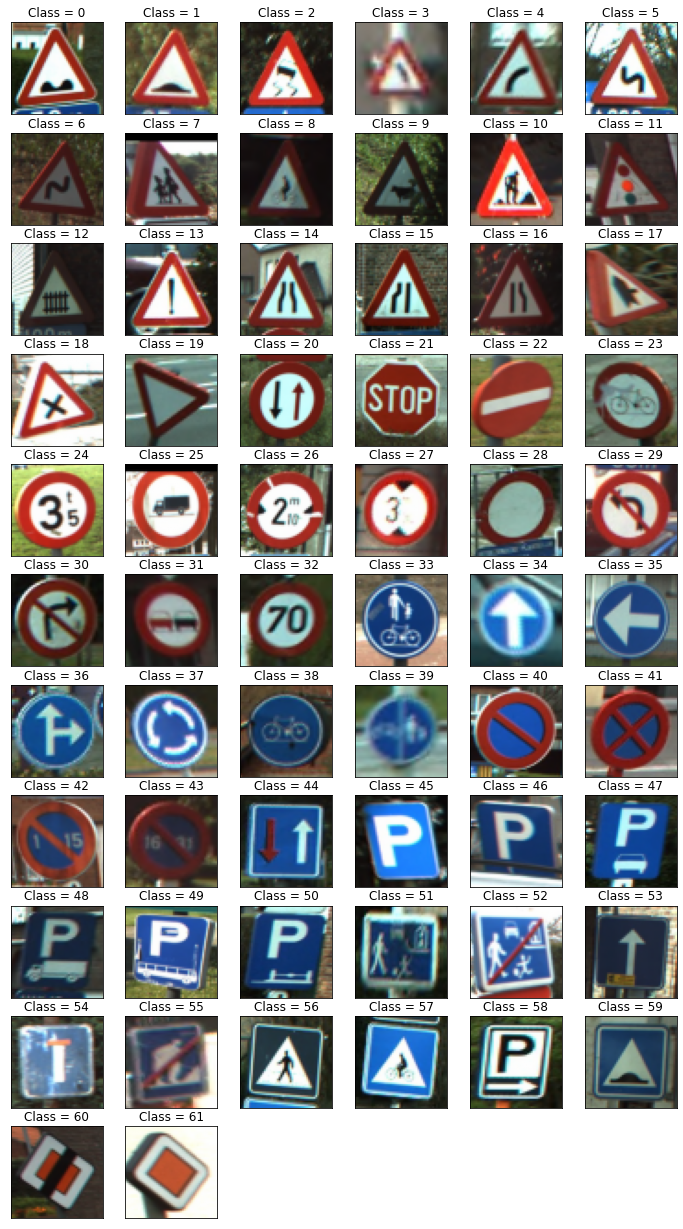

In [ ]:
# Show sample for each class.
class_labels = set(np.unique(y_train))
n_classes = len(class_labels)

n_cols = 6
n_rows = n_classes // n_cols + 1
fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols*2, n_rows*2))
for label in sorted(class_labels):
    row = label // n_cols
    col = label % n_cols
    img_idx = np.argmax(y_train == label)
    ax[row, col].imshow(X_train[img_idx])
    ax[row, col].set_xticks([])
    ax[row, col].set_yticks([])
    ax[row, col].set_title(f'Class = {label}')
    
leftover_subplots = n_cols - (max(class_labels) % n_cols) - 1
for i in range(leftover_subplots):
    fig.delaxes(ax[-1, -(i+1)])


In [ ]:
class MyNeuralNetwork(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.inp_size = input_size
        self.n_classes = num_classes
        self.fnn1 = nn.Linear(input_size, 1024)
        self.fnn2 = nn.Linear(1024, 128)
        self.fnn3 = nn.Linear(128, num_classes)
    
    def forward(self, X):
        output = F.relu(self.fnn1(X))
        output = F.relu(self.fnn2(output))
        output = self.fnn3(output)
        return output


def train_model_FNN(model, dataset, learning_rate, batch_size, epochs): 
    optimizer = opt

    # Train linear model using SGD on mini-batches.
    for epoch in range(epochs):
        # DataLoader generates random batches from a given dataset.
        data_loader = data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, drop_last=True)
         # We want to report the training loss after each epoch
        epoch_loss = 0.0 

        for batch in data_loader:
            # After each iteration of the training step, reset the local gradients stored in the network to zero.
            model.zero_grad()

            # Compute the forward pass.
            # Numpy uses doubles by default but Torch expects floats, since the added accuracy of doubles 
            # is generally not useful for neural networks.
            # We fix this issue by changing the datatype of 'X' and 'y' with the .float method.
            yhat = model.forward(batch['X'].float())

            # Compute the batch error.
            batch_loss = loss(yhat, batch['y'].long())
            epoch_loss += batch_loss.item()
            
            # Backpropagate the gradient and adjust the weights.
            batch_loss.backward()
            optimizer.step()
        
        print(f'Epoch {epoch+1}/{epochs} - Loss: {epoch_loss}')


In [ ]:
input_size = 50*50*3
num_classes = n_classes
learning_rate = 0.0001
batch_size = 64
num_epochs = 10

train_dataset = FlattenedImageDataset(X_train, y_train)
test_dataset = FlattenedImageDataset(X_test, y_test)

model = MyNeuralNetwork(input_size=input_size, num_classes=num_classes)
loss = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=learning_rate)

train_model_FNN(model, train_dataset, learning_rate, batch_size, num_epochs)


Epoch 1/10 - Loss: 226.99396324157715
Epoch 2/10 - Loss: 161.06622397899628
Epoch 3/10 - Loss: 125.42896950244904
Epoch 4/10 - Loss: 102.09836554527283
Epoch 5/10 - Loss: 85.27037453651428
Epoch 6/10 - Loss: 73.04970425367355
Epoch 7/10 - Loss: 62.804538786411285
Epoch 8/10 - Loss: 56.08021405339241
Epoch 9/10 - Loss: 49.59362953901291
Epoch 10/10 - Loss: 43.80446192622185


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score


X_test_flat = torch.from_numpy(np.array([img.flatten() for img in X_test])).float()

def evaluate_FNN_model(model, x):
    scores = model.forward(x).detach().numpy()
    yhat = np.argmax(scores, axis=1)
    pr = precision_score(y_test, yhat, average='macro')
    re = recall_score(y_test, yhat, average='macro')
    f1 = f1_score(y_test, yhat, average='macro')
    acc = accuracy_score(y_test, yhat)
    print(f"Precision = {pr}\nRecall = {re}\nF1-score = {f1}\nAccuracy = {acc}")

evaluate_FNN_model(model, X_test_flat)

Precision = 0.6051441551378244
Recall = 0.5791517608119096
F1-score = 0.570331741872377
Accuracy = 0.8448412698412698


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Task 3: Image Classification with CNN

*For all students other than B.Sc. Data Science.*

In this task, you will implement a convolutional neural network (CNN) for classification of traffic signs.
Your model should use [`nn.Conv2d`](https://pytorch.org/docs/stable/nn.html#torch.nn.Conv2d) layers to compute convolutions, any kind of pooling (e.g. [`nn.MaxPool2d`](https://pytorch.org/docs/stable/nn.html#torch.nn.MaxPool2d)), and a dense output network.
For inspiration look at the architecture of AlexNet (presented in the lecture).
For simplicity, you may use the `nn.Sequential` class.

You should evaluate your model by at least computing the relevant metrics (e.g. F1-score) and looking at a few misclassified samples.

*Note:* For the most part, you can reuse your code from Task 2. However, you have to use images in their original format `(128, 128, 3)` instead of the flattened shape.

In [ ]:
class CNN(nn.Module):
    def __init__(self, in_channels=3, num_classes=62):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=8,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.conv2 = nn.Conv2d(
            in_channels=8,
            out_channels=16,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.fc1 = nn.Linear(16 * 12 * 12, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)
        return x


def train_model_FNN(model, dataset, learning_rate, batch_size, epochs): 
    optimizer = opt

    # Train linear model using SGD on mini-batches.
    for epoch in range(epochs):
        # DataLoader generates random batches from a given dataset.
        data_loader = data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, drop_last=True)
         # We want to report the training loss after each epoch
        epoch_loss = 0.0 

        for batch in data_loader:
            # After each iteration of the training step, reset the local gradients stored in the network to zero.
            model.zero_grad()

            # Compute the forward pass.
            # Numpy uses doubles by default but Torch expects floats, since the added accuracy of doubles 
            # is generally not useful for neural networks.
            # We fix this issue by changing the datatype of 'X' and 'y' with the .float method.
            yhat = model.forward(batch['X'].reshape(-1, 3, 50, 50).float())

            # Compute the batch error.
            batch_loss = loss(yhat, batch['y'].long())
            epoch_loss += batch_loss.item()
            
            # Backpropagate the gradient and adjust the weights.
            batch_loss.backward()
            optimizer.step()
        
        print(f'Epoch {epoch+1}/{epochs} - Loss: {epoch_loss}')

In [ ]:
class ImageDataset(data.Dataset):
    def __init__(self, X, y):
        self.X = np.array([img for img in X])
        self.y = y
        
    def __getitem__(self, idx):
        return dict(X=self.X[idx], y=self.y[idx])
    
    def __len__(self):
        return self.X.shape[0]

In [ ]:
num_classes = n_classes
learning_rate = 0.0001
batch_size = 64
num_epochs = 10

train_dataset = ImageDataset(X_train, y_train)
test_dataset = ImageDataset(X_test, y_test)

cnn_model = CNN(in_channels=3, num_classes=num_classes)
loss = nn.CrossEntropyLoss()
opt = optim.Adam(cnn_model.parameters(), lr=learning_rate)

train_model_FNN(cnn_model, train_dataset, learning_rate, batch_size, num_epochs)

X_test_flat = torch.from_numpy(np.array([img for img in X_test])).reshape(-1, 3, 50, 50).float()

evaluate_FNN_model(cnn_model, X_test_flat)

Epoch 1/10 - Loss: 266.7583954334259
Epoch 2/10 - Loss: 245.9398684501648
Epoch 3/10 - Loss: 230.32350635528564
Epoch 4/10 - Loss: 209.08620953559875
Epoch 5/10 - Loss: 184.54592096805573
Epoch 6/10 - Loss: 162.5100358724594
Epoch 7/10 - Loss: 144.71590542793274
Epoch 8/10 - Loss: 130.79772067070007
Epoch 9/10 - Loss: 118.99080896377563
Epoch 10/10 - Loss: 110.0055536031723
Precision = 0.37126485558133415
Recall = 0.35640487296406353
F1-score = 0.32542125012079065
Accuracy = 0.6015873015873016


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
